In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg as slinalg

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam, Optimizer
import keras2.backend as K
import tensorflow as tf
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2, selfDDPGAgent3
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def value_net(s_shape):
    state_input = Input((1,)+s_shape)
    x = Flatten()(state_input)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation="linear")(x)
    value = Model(inputs=state_input, output=x)
    return value

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(32, activation="relu")(x)
    x1 = Dense(32, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(32, activation="relu")(x)
    x2 = Dense(32, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [3]:
env = gym2.make('Linear-v4')

In [4]:
Q = 1.*np.eye(3)
R = 1

In [5]:
def dlqr(A, B, Q, R, dt):
    A, B = discretized_system(A, B.reshape(len(B),1), dt)
    P = scipy.linalg.solve_discrete_are(A, B, Q, R)
    K = np.linalg.inv(np.dot(B.T, P).dot(B) + R).dot(B.T).dot(P).dot(A)[0]
    return -K


def discretized_system(A, B, dt):
    Ad = np.eye(A.shape[0]) + dt * A
    Bd = dt * B
    return Ad, Bd

In [15]:
T = dlqr(env.A, env.B, Q, R, 0.15)

In [16]:
l = .5
env.reset()
initial_state = np.array([3.,3.,3.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    # a_agent, tau = control_law(x, env)
    a_agent, tau = np.clip(np.dot(T, x), -10, 10), 0.15
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=1)
        reward += r
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    #print(env.state, tau)
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(np.clip(np.dot(T, x), -10, 10))
states = np.array(states)
detail_states = np.array(detail_states)

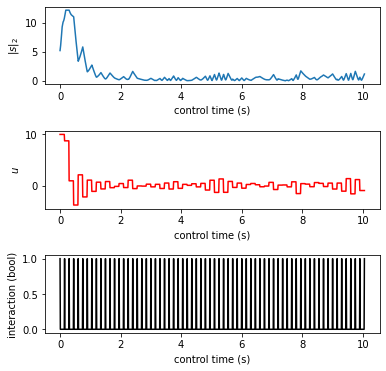

In [17]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [23]:
x_train = []
y_train = []
high = np.array([7, 7, 7])
tau = 0.15
for i in range(30000):
    x_train.append([np.random.uniform(low=-high, high=high)])
    y_train.append([np.clip(np.dot(T, x_train[-1][0]), -10, 10), tau])

x_train = np.array(x_train)
y_train = np.array(y_train)

In [24]:
actor = branch_actor((2,),(3,))

In [25]:
# 学習
actor.compile(loss='mean_squared_error',optimizer=Adam(lr=0.001, clipnorm=1.))
actor.fit(x_train, y_train, batch_size=32, epochs=100, verbose=True)

Epoch 1/100
30000/30000 [==============================] - 3s 83us/step - loss: 1.0055
Epoch 2/100
30000/30000 [==============================] - 2s 65us/step - loss: 0.0535
Epoch 3/100
30000/30000 [==============================] - 2s 65us/step - loss: 0.0287
Epoch 4/100
30000/30000 [==============================] - 3s 84us/step - loss: 0.0168
Epoch 5/100
30000/30000 [==============================] - 2s 63us/step - loss: 0.0113
Epoch 6/100
30000/30000 [==============================] - 2s 60us/step - loss: 0.0087
Epoch 7/100
30000/30000 [==============================] - 2s 60us/step - loss: 0.0067
Epoch 8/100
30000/30000 [==============================] - 2s 58us/step - loss: 0.0058
Epoch 9/100
30000/30000 [==============================] - 2s 59us/step - loss: 0.0051TA: 0s - loss: 0
Epoch 10/100
30000/30000 [==============================] - 2s 59us/step - loss: 0.0044
Epoch 11/100
30000/30000 [==============================] - 2s 60us/step - loss: 0.0037
Epoch 12/100
30000/30000 

KeyboardInterrupt: 

In [26]:
l = .5
env.reset()
initial_state = np.array([3.,-3.,3.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    # a_agent, tau = control_law(x, env)
    a_agent, tau = actor.predict_on_batch(x.reshape(1,1,3))[0]
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=1)
        reward += r
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    #print(env.state, tau)
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(actor.predict_on_batch(env.state.reshape(1,1,3))[0][0])
states = np.array(states)
detail_states = np.array(detail_states)

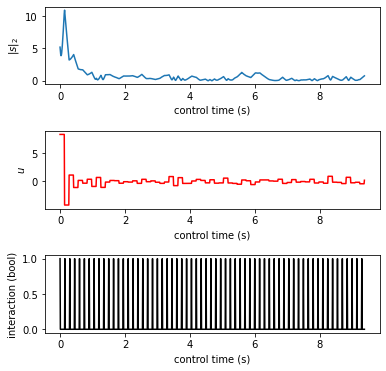

In [27]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [ ]:
alpha = 0.1
beta = .5

memory = []
S1 = np.linspace(-7, 7, 10)
S2 = np.linspace(-7, 7, 10)
S3 = np.linspace(-7, 7, 10)
S1, S2, S3 = np.meshgrid(S1, S2, S3)
S1, S2, S3 = S1.flatten(), S2.flatten(), S3.flatten()

nn = 5
for st in range(nn):
    for i, x in enumerate(zip(S1, S2, S3)):
        env.reset()
        x = np.array(x)
        env.set_state(x)
        reward = 0
        state0 = env.state
        noise = np.array([np.random.randn() / 10., np.random.randn() / 100.])
        a_agent, tau = actor.predict_on_batch(state0.reshape((1,1,)+state0.shape))[0] + noise
        tau = np.clip(tau, 0.01, 10.)
        action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
        dt = .01
        for p in range(action_repetition):
            _,r,_,_ = env.step(np.array([a_agent]), dt, tau, 0)
            r *= np.exp(- alpha * p * dt)
            reward += r
        reward *= dt
        reward -= beta
        state1 = env.state
        memory.append([state0, np.array([a_agent, tau]), reward, state1])
    print('\r' + f'{int(st)*100/nn} %', end='')
memory = np.array(memory)

In [ ]:
# critic learning
critic = critic_net((2,),(3,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
epoch = 10000
batch_size = 64
arr = np.array(range(memory.shape[0]))
losses = []
for _ in range(epoch):
    # make mini_batch
    mem = memory[np.random.choice(arr, batch_size, replace=False)]
    state0_batch = []
    action_batch = []
    reward_batch = []
    state1_batch = []
    for m in mem:
        state0_batch.append([m[0]])
        action_batch.append(m[1])
        reward_batch.append([m[2]])
        state1_batch.append([m[3]])
    state0_batch, action_batch, reward_batch, state1_batch = \
    np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

    # TD error
    next_action = actor.predict_on_batch(state1_batch)
    state1_batch_with_action = [next_action, state1_batch]
    target = critic.predict_on_batch(state1_batch_with_action)
    discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
    r_second = np.multiply(discount, target)
    r = reward_batch + r_second
    
    # learn
    critic_input_batch = [action_batch, state0_batch]
    loss = critic.train_on_batch(critic_input_batch, r)
    losses.append(loss)
    
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('critic_loss')
plt.show()